# Pruebas Dinamicas de Agente Industrial

In [1]:
# Importo todas las librerias utilizadas

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import random
import shutil
import numpy as np
import matplotlib.image as mpimg
import cv2
from pathlib import Path
import shutil
from typing import List, Tuple, Dict, Optional

# Agrego Path de src
srcPath = str(Path.cwd() / "src")
if srcPath not in sys.path:
    sys.path.append(srcPath)

# Importo e instancio ImagePreprocessor
from src.agent.ImagePreprocessor import ImagePreprocessor


In [2]:
# Configuracion de matplotlib y paths
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

BASE_PATH = Path("data/raw/images")
ALL_PATH = BASE_PATH / "all"
TRAIN_PATH = BASE_PATH / "train"
TEST_PATH = BASE_PATH / "test"

print("📍 Estructura de directorios:")
print(f"Base: {BASE_PATH}")
print(f"All: {ALL_PATH}")
print(f"Train: {TRAIN_PATH}")
print(f"Test: {TEST_PATH}")

📍 Estructura de directorios:
Base: data/raw/images
All: data/raw/images/all
Train: data/raw/images/train
Test: data/raw/images/test


## Analisis de Base de Datos

### Analisis Inicial y Metodos auxiliares

Comenzamos creando un metodo para entender como esta estructurado el dataset de imagenes y poder seleccionar y mostrarla

In [3]:
def analyze_dataset_structure():
    """Analiza la estructura actual del dataset"""
    print("🔍 ANALIZANDO ESTRUCTURA DEL DATASET")
    
    # Encontrar todas las clases (subdirectorios de train)
    classes = [d.name for d in ALL_PATH.iterdir() if d.is_dir()]
    print(f"🏷️  Clases encontradas: {classes}")
    
    if not classes:
        print("❌ No se encontraron subdirectorios de clases en 'train/'")
        print("   La estructura debería ser: data/raw/images/train/tornillos/, etc.")
        return {}, []
    
    stats = {}
    total_images = 0
    
    # Extensiones de imagen válidas
    valid_extensions = {'.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG'}
    
    for class_name in classes:
        class_path = ALL_PATH / class_name

        # Contar imágenes usando iterdir() en lugar de glob
        image_files = []
        for file_path in class_path.iterdir():
            if file_path.is_file() and file_path.suffix in valid_extensions:
                image_files.append(file_path)
        
        stats[class_name] = len(image_files)
        total_images += len(image_files)
        
        print(f"   {class_name}: {len(image_files)} imágenes")
    
    print(f"📊 Total de imágenes: {total_images}")
    return stats, classes

In [4]:
def get_random_image(class_name: str, seed: int = None):
    """
    Visualiza una imagen aleatoria de una clase dada.

    Args:
        class_name (str): Nombre de la clase (subdirectorio).
        seed (int|None): Semilla para reproductibilidadad.
    """

    class_path = ALL_PATH / class_name

    # Obtener todas las imágenes de la clase
    image_files = list(class_path.glob("*.jpg")) + list(class_path.glob("*.jpeg")) + \
                  list(class_path.glob("*.JPG")) + list(class_path.glob("*.JPEG"))

    if not image_files:
        print(f"No se encontraron imágenes en {class_path}")
        return
    
    # Seleccionar una imagen aleatoria
    rng = random.Random(seed) if seed is not None else random
    random_img_path = rng.choice(image_files)
    
    # Cargar y mostrar la imagen
    img_path = random_img_path
    img = mpimg.imread(random_img_path)

    return img_path, img

In [5]:
def plot_image(image: np.ndarray, title: str = "Imagen"):
    """
    Muestra una imagen usando matplotlib.

    Args:
        image (np.ndarray): Imagen a mostrar.
        title (str): Título de la imagen.
    """
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')
    plt.title(title)
    plt.show()

🔍 ANALIZANDO ESTRUCTURA DEL DATASET
🏷️  Clases encontradas: ['arandelas', 'clavos', 'tuercas', 'tornillos']
   arandelas: 30 imágenes
   clavos: 23 imágenes
   tuercas: 20 imágenes
   tornillos: 54 imágenes
📊 Total de imágenes: 127
Se selecciono la imagen data/raw/images/all/tornillos/IMG_2876.JPG


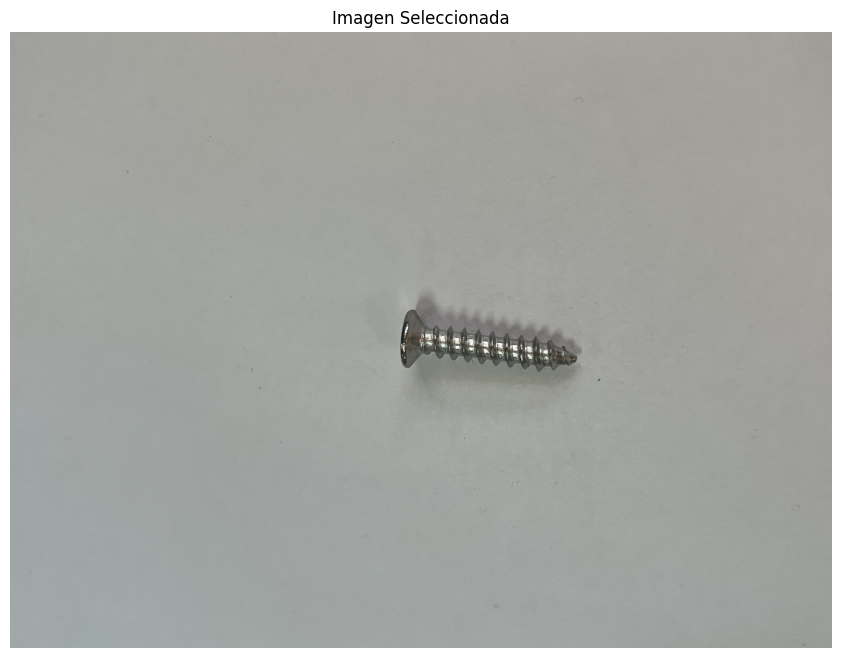

In [6]:
initial_stats, classes = analyze_dataset_structure()

imagen_path, random_image = get_random_image("tornillos")

print(f"Se selecciono la imagen {imagen_path}")
plot_image(random_image, title="Imagen Seleccionada")

## ImagePreprocessor

Se selecciono la imagen data/raw/images/all/tornillos/IMG_2850.JPG


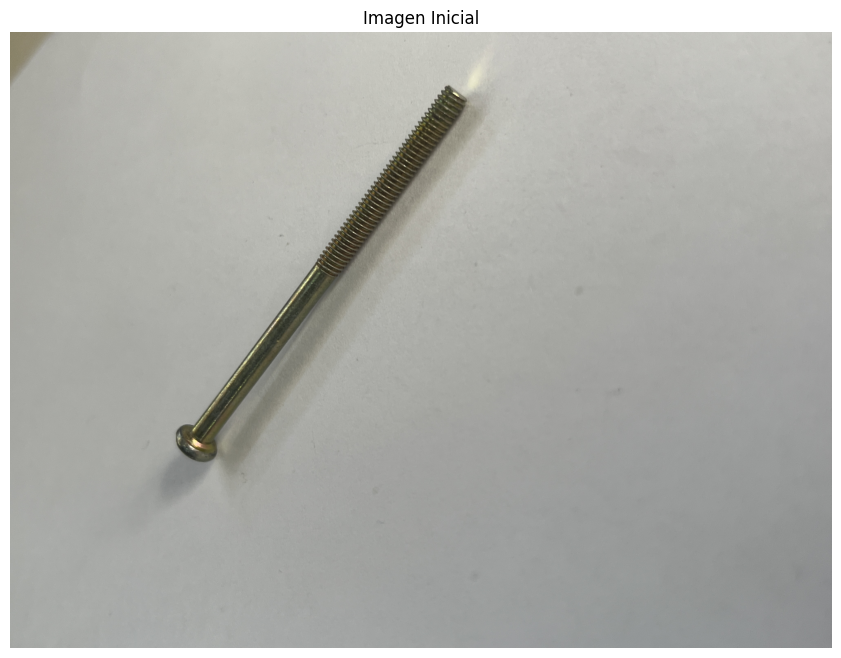

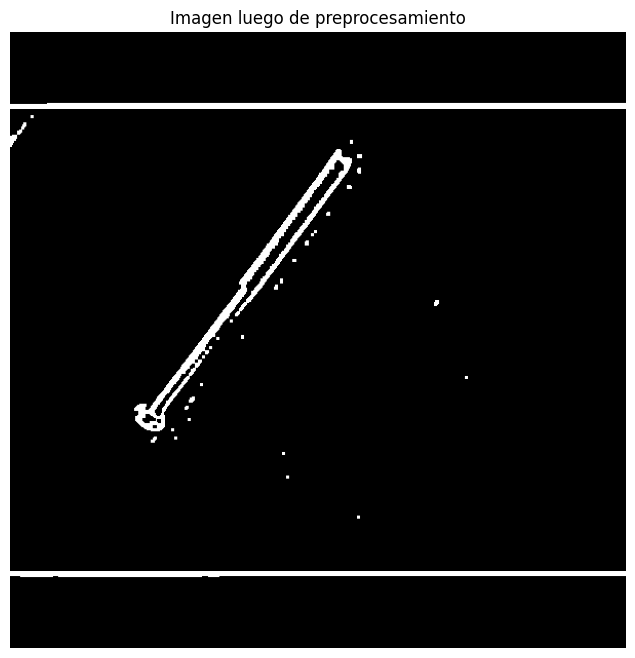

In [7]:
# Agrego Path de ImagePreprocesor

procesador_imagenes = ImagePreprocessor(target_size=(600,600))

#! 1. Eligo una imagen aleatoria
path_image, image = get_random_image("tornillos")
print(f"Se selecciono la imagen {path_image}")

plot_image(image, title="Imagen Inicial")
binary_image = procesador_imagenes.process(image)
plot_image(binary_image, title="Imagen luego de preprocesamiento")

## Segmentator

In [8]:
def _quick_visualization(binary_image: np.ndarray, result: Dict):
    """Quick visualization of the segmentation results"""
    # Create visualization image
    vis_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)
    
    # Draw bounding boxes
    for i, bbox in enumerate(result["bounding_boxes"]):
        x, y, w, h = bbox
        cv2.rectangle(vis_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(vis_image, str(i+1), (x, y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Create mask overlay
    mask_overlay = np.zeros_like(vis_image)
    for mask in result["masks"]:
        mask_overlay[mask > 0] = [0, 0, 255]  # Red for masks
    
    # Blend with original
    final_vis = cv2.addWeighted(vis_image, 0.7, mask_overlay, 0.3, 0)
    
    # Add title
    cv2.putText(final_vis, f"Objects: {result['total_objects']}", 
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Resize if too large
    h, w = final_vis.shape[:2]
    if w > 800:
        final_vis = cv2.resize(final_vis, (800, int(800 * h / w)))
    
    # Display
    cv2.imshow('Segmentation Test Result', final_vis)
    cv2.waitKey(3000)  # Show for 3 seconds
    cv2.destroyAllWindows()

Se selecciono la imagen data/raw/images/all/tornillos/IMG_2830.JPG


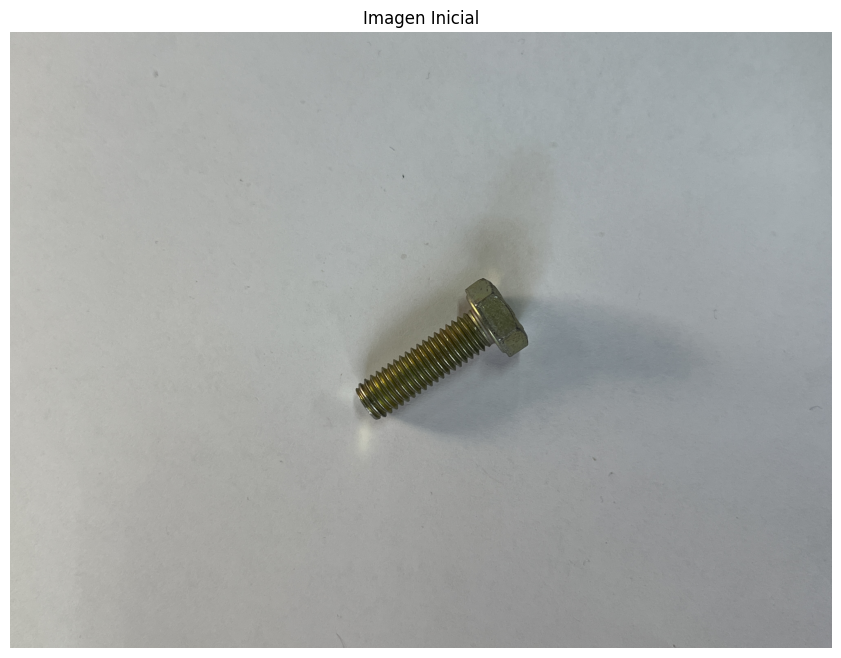

🚀 INICIANDO PROCESO DE SEGMENTACIÓN
   Contornos encontrados: 19
   Contornos validos: 7
   Bounding boxes: 7
   Bounding boxes despues de fusion: 3
   Eliminados por aspecto excesivo: 2
    Mascaras extraidas: 1

🔍 Checking data consistency...
   Bounding boxes: 1
   Contours: 1
   Masks: 1
   Total objects: 1
   ✅ All counts match!

🎭 Validating masks...
   Mask 1: 1520 pixels
      ✅ Mask 1 fits perfectly in bounding box


In [ ]:
# TEST
from src.agent.Segmentator import Segmentator

#Eligo una imagen aleatoria
path_image, image = get_random_image("tornillos")
print(f"Se selecciono la imagen {path_image}")

#img_path = BASE_PATH / "multi_test" / "WhatsApp Image 2025-10-16 at 12.47.44.JPG"
#image = mpimg.imread(img_path)



plot_image(image, title="Imagen Inicial")
binary_image = procesador_imagenes.process(image)

#Instanciar segmentador
segmentator = Segmentator(
    min_contour_area=25,
    min_mask_area=150,
    merge_close_boxes=True,
    overlap_threshold=0.3,
    max_distance=5
)

# Realizo segmentacion de la imagen binaria
result = segmentator.process(binary_image)

print(f"================")
# Check data consistency
print("\n🔍 Checking data consistency...")
bbox_count = len(result["bounding_boxes"])
contour_count = len(result["contours"])
mask_count = len(result["masks"])
total_objects = result["total_objects"]
    
print(f"   Bounding boxes: {bbox_count}")
print(f"   Contours: {contour_count}")
print(f"   Masks: {mask_count}")
print(f"   Total objects: {total_objects}")
    
# Check if counts match
if bbox_count == contour_count == mask_count == total_objects:
    print("   ✅ All counts match!")
else:
    print("   ⚠️  Counts don't match - this might indicate a problem")


print("\n🎭 Validating masks...")
for i, mask in enumerate(result["masks"]):
    mask_area = np.sum(mask > 0)
    print(f"   Mask {i+1}: {mask_area} pixels")
        
    # Check if mask is entirely within its bounding box
    if i < len(result["bounding_boxes"]):
        x, y, w, h = result["bounding_boxes"][i]
        mask_roi = mask[y:y+h, x:x+w]
        roi_area = np.sum(mask_roi > 0)
            
        if mask_area == roi_area:
            print(f"      ✅ Mask {i+1} fits perfectly in bounding box")
        else:
            print(f"      ⚠️  Mask {i+1} extends outside bounding box")

_quick_visualization(binary_image, result)

## FeatureExtractor

In [10]:
from src.agent.FeatureExtractor import FeatureExtractor

#Eligo una imagen aleatoria
path_image, image = get_random_image("tornillos")
print(f"Se selecciono la imagen {path_image}")

#img_path = BASE_PATH / "multi_test" / "WhatsApp Image 2025-10-16 at 12.47.44.JPG"
#image = mpimg.imread(img_path)

binary_image = procesador_imagenes.process(image)

#Instanciar segmentador
segmentator = Segmentator(
    min_contour_area=25,
    merge_close_boxes=True,
    overlap_threshold=0.3,
    max_distance=5
)

# Realizo segmentacion de la imagen binaria
result = segmentator.process(binary_image)

# Instanciar FeatureExtractor
extractor = FeatureExtractor()

features = extractor.extract_features(image, result["bounding_boxes"], result["masks"])



Se selecciono la imagen data/raw/images/all/tornillos/IMG_2788.JPG
🚀 INICIANDO PROCESO DE SEGMENTACIÓN
   Contornos encontrados: 8
   Contornos validos: 4
   Bounding boxes: 4
   Bounding boxes despues de fusion: 2
   Eliminados por aspecto excesivo: 1
    Mascaras extraidas: 1
🔍 Analizando objeto 1...
   Objeto 1:
     📐 Área: 1378 píxeles
     📏 Esbeltez: 1.17
     🔴 Redondez: 0.043


### Dividir el dataset en Train y Test

In [11]:
import random
import shutil
from pathlib import Path

def split_dataset():
    """
    Divide el dataset 70-30 entre train y test desde el directorio all
    """

    # Crear directorio train y test si no existen
    TRAIN_PATH.mkdir(parents=True, exist_ok=True)
    TEST_PATH.mkdir(parents=True, exist_ok=True)
    
    # Para cada clase en train
    for class_dir in ALL_PATH.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            print(f"Procesando clase: {class_name}")
            
            # Obtener todas las imágenes
            image_files = list(class_dir.glob("*.*"))
            random.shuffle(image_files)
            
            # Calcular splits
            split_index = int(0.7 * len(image_files))
            train_images = image_files[:split_index]
            test_images = image_files[split_index:]
            
            # Crear directorios de clase en test
            train_class_dir = TRAIN_PATH / class_name
            test_class_dir = TEST_PATH / class_name
            train_class_dir.mkdir(exist_ok=True)
            test_class_dir.mkdir(exist_ok=True)
            
            # Copiar imágenes a train
            for image in train_images:
                shutil.copy2(str(image), str(train_class_dir / image.name))

            # Copiar imágenes a test
            for image in test_images:
                shutil.copy2(str(image), str(test_class_dir / image.name))
            
            print(f"  Train: {len(train_images)} imágenes")
            print(f"  Test: {len(test_images)} imágenes")
            print(f"  Total: {len(image_files)} imágenes")

In [12]:
# Solo ejecutar 1 vez
#split_dataset()